<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:01:26] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


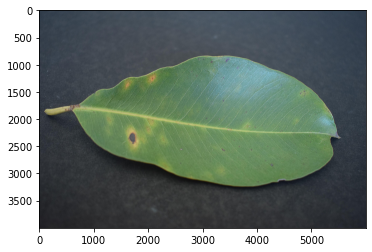

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

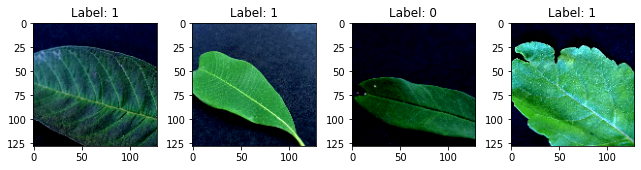

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:01:32] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:01:34] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2581740325432194 samples/sec                   batch loss = 0.3055003881454468 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2199429047603119 samples/sec                   batch loss = 0.6541978716850281 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2605478327301536 samples/sec                   batch loss = 0.5446907877922058 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2525889142268736 samples/sec                   batch loss = 0.5062702894210815 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.256082755299632 samples/sec                   batch loss = 1.782711386680603 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.254765497167783 samples/sec                   batch loss = 0.8214400410652161 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2531981088955901 samples/sec                   batch loss = 0.5961374640464783 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2585891395140514 samples/sec                   batch loss = 0.33570408821105957 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2477448549687264 samples/sec                   batch loss = 0.7291162014007568 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2580308190712228 samples/sec                   batch loss = 0.8474858999252319 | accuracy = 0.585


Epoch[1] Batch[55] Speed: 1.2528678483016642 samples/sec                   batch loss = 0.4524554908275604 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.2500295049955832 samples/sec                   batch loss = 0.7810276746749878 | accuracy = 0.5958333333333333


Epoch[1] Batch[65] Speed: 1.2580210085378913 samples/sec                   batch loss = 0.5912375450134277 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2526042514380462 samples/sec                   batch loss = 1.2183470726013184 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.2532008235747218 samples/sec                   batch loss = 0.8468473553657532 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.2497936343660592 samples/sec                   batch loss = 0.8060465455055237 | accuracy = 0.596875


Epoch[1] Batch[85] Speed: 1.2541370591122496 samples/sec                   batch loss = 0.41200223565101624 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.262856647781644 samples/sec                   batch loss = 1.16425621509552 | accuracy = 0.5861111111111111


Epoch[1] Batch[95] Speed: 1.2566654205288263 samples/sec                   batch loss = 0.9385459423065186 | accuracy = 0.5789473684210527


Epoch[1] Batch[100] Speed: 1.2517472531227622 samples/sec                   batch loss = 0.3425840139389038 | accuracy = 0.5925


Epoch[1] Batch[105] Speed: 1.2558402707316334 samples/sec                   batch loss = 1.007852554321289 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.254137715360825 samples/sec                   batch loss = 0.5199065804481506 | accuracy = 0.6045454545454545


Epoch[1] Batch[115] Speed: 1.2548522147628318 samples/sec                   batch loss = 0.3156399726867676 | accuracy = 0.6130434782608696


Epoch[1] Batch[120] Speed: 1.2486507422145838 samples/sec                   batch loss = 0.5659309029579163 | accuracy = 0.6104166666666667


Epoch[1] Batch[125] Speed: 1.2519726505293596 samples/sec                   batch loss = 1.300248384475708 | accuracy = 0.61


Epoch[1] Batch[130] Speed: 1.2540521275930971 samples/sec                   batch loss = 0.4125036597251892 | accuracy = 0.6153846153846154


Epoch[1] Batch[135] Speed: 1.2531269697730425 samples/sec                   batch loss = 0.5011259913444519 | accuracy = 0.6166666666666667


Epoch[1] Batch[140] Speed: 1.2557067984454495 samples/sec                   batch loss = 1.102074146270752 | accuracy = 0.6196428571428572


Epoch[1] Batch[145] Speed: 1.2594903292552257 samples/sec                   batch loss = 0.8058995604515076 | accuracy = 0.6241379310344828


Epoch[1] Batch[150] Speed: 1.2544332845159676 samples/sec                   batch loss = 0.3855069577693939 | accuracy = 0.63


Epoch[1] Batch[155] Speed: 1.252072437917164 samples/sec                   batch loss = 1.3284718990325928 | accuracy = 0.6306451612903226


Epoch[1] Batch[160] Speed: 1.2586308730068527 samples/sec                   batch loss = 1.8414520025253296 | accuracy = 0.634375


Epoch[1] Batch[165] Speed: 1.2541904987453023 samples/sec                   batch loss = 0.4168529510498047 | accuracy = 0.6363636363636364


Epoch[1] Batch[170] Speed: 1.2516082066901726 samples/sec                   batch loss = 0.9640834331512451 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.2508758515922795 samples/sec                   batch loss = 0.3879118859767914 | accuracy = 0.6357142857142857


Epoch[1] Batch[180] Speed: 1.2566849053539766 samples/sec                   batch loss = 0.7820370197296143 | accuracy = 0.6388888888888888


Epoch[1] Batch[185] Speed: 1.2510593264574799 samples/sec                   batch loss = 0.5998746156692505 | accuracy = 0.6445945945945946


Epoch[1] Batch[190] Speed: 1.251471991690876 samples/sec                   batch loss = 0.43227875232696533 | accuracy = 0.6473684210526316


Epoch[1] Batch[195] Speed: 1.2523634818585798 samples/sec                   batch loss = 0.9464151263237 | accuracy = 0.6435897435897436


Epoch[1] Batch[200] Speed: 1.2530608925081488 samples/sec                   batch loss = 0.4283064603805542 | accuracy = 0.6425


Epoch[1] Batch[205] Speed: 1.2585028487165828 samples/sec                   batch loss = 0.4774581789970398 | accuracy = 0.6487804878048781


Epoch[1] Batch[210] Speed: 1.256985160993099 samples/sec                   batch loss = 0.6401761770248413 | accuracy = 0.6476190476190476


Epoch[1] Batch[215] Speed: 1.2631549148418528 samples/sec                   batch loss = 1.0049582719802856 | accuracy = 0.6523255813953488


Epoch[1] Batch[220] Speed: 1.2588218248697283 samples/sec                   batch loss = 0.6819855570793152 | accuracy = 0.6534090909090909


Epoch[1] Batch[225] Speed: 1.2615653721494737 samples/sec                   batch loss = 0.7823591232299805 | accuracy = 0.6555555555555556


Epoch[1] Batch[230] Speed: 1.2700437723046816 samples/sec                   batch loss = 0.5685431957244873 | accuracy = 0.6543478260869565


Epoch[1] Batch[235] Speed: 1.2638906780655679 samples/sec                   batch loss = 0.7150866985321045 | accuracy = 0.6585106382978724


Epoch[1] Batch[240] Speed: 1.2664723262714401 samples/sec                   batch loss = 1.008371114730835 | accuracy = 0.6583333333333333


Epoch[1] Batch[245] Speed: 1.2644203829749423 samples/sec                   batch loss = 0.2762784957885742 | accuracy = 0.6632653061224489


Epoch[1] Batch[250] Speed: 1.2576733051052018 samples/sec                   batch loss = 0.4073253870010376 | accuracy = 0.663


Epoch[1] Batch[255] Speed: 1.2576676483799332 samples/sec                   batch loss = 0.576899528503418 | accuracy = 0.6627450980392157


Epoch[1] Batch[260] Speed: 1.2637875701158803 samples/sec                   batch loss = 0.18783286213874817 | accuracy = 0.6634615384615384


Epoch[1] Batch[265] Speed: 1.2665877296052332 samples/sec                   batch loss = 0.4247526526451111 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.2619039363269087 samples/sec                   batch loss = 0.5306291580200195 | accuracy = 0.6685185185185185


Epoch[1] Batch[275] Speed: 1.2633413438549932 samples/sec                   batch loss = 0.7679281234741211 | accuracy = 0.6672727272727272


Epoch[1] Batch[280] Speed: 1.264213725249362 samples/sec                   batch loss = 0.5695875287055969 | accuracy = 0.6705357142857142


Epoch[1] Batch[285] Speed: 1.2593048459531289 samples/sec                   batch loss = 0.7555077075958252 | accuracy = 0.6684210526315789


Epoch[1] Batch[290] Speed: 1.2625492103393299 samples/sec                   batch loss = 0.539793848991394 | accuracy = 0.6698275862068965


Epoch[1] Batch[295] Speed: 1.2693714161544707 samples/sec                   batch loss = 0.7300177216529846 | accuracy = 0.6711864406779661


Epoch[1] Batch[300] Speed: 1.2620666408043 samples/sec                   batch loss = 0.6310656666755676 | accuracy = 0.6708333333333333


Epoch[1] Batch[305] Speed: 1.2570304612988403 samples/sec                   batch loss = 0.5955238342285156 | accuracy = 0.6721311475409836


Epoch[1] Batch[310] Speed: 1.2611954177482196 samples/sec                   batch loss = 0.5119929313659668 | accuracy = 0.6733870967741935


Epoch[1] Batch[315] Speed: 1.2666765672080027 samples/sec                   batch loss = 0.3429790139198303 | accuracy = 0.6761904761904762


Epoch[1] Batch[320] Speed: 1.2585640252165664 samples/sec                   batch loss = 0.34445708990097046 | accuracy = 0.67421875


Epoch[1] Batch[325] Speed: 1.2575387831075973 samples/sec                   batch loss = 0.67621910572052 | accuracy = 0.6738461538461539


Epoch[1] Batch[330] Speed: 1.2561583687057745 samples/sec                   batch loss = 0.5804833173751831 | accuracy = 0.6727272727272727


Epoch[1] Batch[335] Speed: 1.2495715336418058 samples/sec                   batch loss = 0.4822523295879364 | accuracy = 0.6723880597014925


Epoch[1] Batch[340] Speed: 1.2541107159865625 samples/sec                   batch loss = 0.42179635167121887 | accuracy = 0.6720588235294118


Epoch[1] Batch[345] Speed: 1.2524107869423393 samples/sec                   batch loss = 0.5128960013389587 | accuracy = 0.6702898550724637


Epoch[1] Batch[350] Speed: 1.2562400113095338 samples/sec                   batch loss = 0.4993971586227417 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.2520966396896316 samples/sec                   batch loss = 0.31179141998291016 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.2612407375889254 samples/sec                   batch loss = 0.30119746923446655 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.2560724108897838 samples/sec                   batch loss = 0.6167879700660706 | accuracy = 0.6732876712328767


Epoch[1] Batch[370] Speed: 1.2625337236348733 samples/sec                   batch loss = 0.33968228101730347 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.259030502711192 samples/sec                   batch loss = 0.7467047572135925 | accuracy = 0.6753333333333333


Epoch[1] Batch[380] Speed: 1.2729908389392541 samples/sec                   batch loss = 0.5096908211708069 | accuracy = 0.6763157894736842


Epoch[1] Batch[385] Speed: 1.2655866107382703 samples/sec                   batch loss = 0.6271193027496338 | accuracy = 0.6779220779220779


Epoch[1] Batch[390] Speed: 1.2693997489379498 samples/sec                   batch loss = 0.8817070126533508 | accuracy = 0.6788461538461539


Epoch[1] Batch[395] Speed: 1.264169715594486 samples/sec                   batch loss = 0.5193386673927307 | accuracy = 0.6772151898734177


Epoch[1] Batch[400] Speed: 1.2626006137197021 samples/sec                   batch loss = 0.48375239968299866 | accuracy = 0.67875


Epoch[1] Batch[405] Speed: 1.2556079344538738 samples/sec                   batch loss = 0.5051613450050354 | accuracy = 0.678395061728395


Epoch[1] Batch[410] Speed: 1.2563662584371356 samples/sec                   batch loss = 0.5782179236412048 | accuracy = 0.6798780487804879


Epoch[1] Batch[415] Speed: 1.25045388648243 samples/sec                   batch loss = 0.38323378562927246 | accuracy = 0.6801204819277108


Epoch[1] Batch[420] Speed: 1.2584863283052037 samples/sec                   batch loss = 0.7459698915481567 | accuracy = 0.6797619047619048


Epoch[1] Batch[425] Speed: 1.2567578611525543 samples/sec                   batch loss = 0.6312141418457031 | accuracy = 0.6817647058823529


Epoch[1] Batch[430] Speed: 1.249853594614457 samples/sec                   batch loss = 0.37985509634017944 | accuracy = 0.6831395348837209


Epoch[1] Batch[435] Speed: 1.2549969584836762 samples/sec                   batch loss = 1.6968857049942017 | accuracy = 0.6839080459770115


Epoch[1] Batch[440] Speed: 1.25321027823868 samples/sec                   batch loss = 0.5113246440887451 | accuracy = 0.6835227272727272


Epoch[1] Batch[445] Speed: 1.2559704805445737 samples/sec                   batch loss = 0.7566123008728027 | accuracy = 0.6803370786516854


Epoch[1] Batch[450] Speed: 1.2547967479066735 samples/sec                   batch loss = 0.4821944534778595 | accuracy = 0.6783333333333333


Epoch[1] Batch[455] Speed: 1.2509153962760526 samples/sec                   batch loss = 0.7541770339012146 | accuracy = 0.6780219780219781


Epoch[1] Batch[460] Speed: 1.2508090789811237 samples/sec                   batch loss = 0.2139928787946701 | accuracy = 0.6777173913043478


Epoch[1] Batch[465] Speed: 1.251780595240609 samples/sec                   batch loss = 0.3590797483921051 | accuracy = 0.678494623655914


Epoch[1] Batch[470] Speed: 1.250654111931841 samples/sec                   batch loss = 0.3309210240840912 | accuracy = 0.6803191489361702


Epoch[1] Batch[475] Speed: 1.251414209637712 samples/sec                   batch loss = 0.7015396356582642 | accuracy = 0.6784210526315789


Epoch[1] Batch[480] Speed: 1.2507486540479131 samples/sec                   batch loss = 0.42076483368873596 | accuracy = 0.6786458333333333


Epoch[1] Batch[485] Speed: 1.246624879227107 samples/sec                   batch loss = 0.3614187240600586 | accuracy = 0.6783505154639176


Epoch[1] Batch[490] Speed: 1.2514393194382119 samples/sec                   batch loss = 0.6754212975502014 | accuracy = 0.6780612244897959


Epoch[1] Batch[495] Speed: 1.2465913480674962 samples/sec                   batch loss = 0.4956885576248169 | accuracy = 0.6787878787878788


Epoch[1] Batch[500] Speed: 1.25015106014828 samples/sec                   batch loss = 0.5641692876815796 | accuracy = 0.678


Epoch[1] Batch[505] Speed: 1.2511433865540322 samples/sec                   batch loss = 0.3459009528160095 | accuracy = 0.6797029702970298


Epoch[1] Batch[510] Speed: 1.2559306156114276 samples/sec                   batch loss = 0.4278568625450134 | accuracy = 0.6808823529411765


Epoch[1] Batch[515] Speed: 1.256645653932317 samples/sec                   batch loss = 0.3799075782299042 | accuracy = 0.6815533980582524


Epoch[1] Batch[520] Speed: 1.2600467286034585 samples/sec                   batch loss = 0.3216971755027771 | accuracy = 0.6826923076923077


Epoch[1] Batch[525] Speed: 1.2551506561644445 samples/sec                   batch loss = 1.0662223100662231 | accuracy = 0.6814285714285714


Epoch[1] Batch[530] Speed: 1.2592545612206978 samples/sec                   batch loss = 0.39712226390838623 | accuracy = 0.6820754716981132


Epoch[1] Batch[535] Speed: 1.2601977847334678 samples/sec                   batch loss = 0.9014581441879272 | accuracy = 0.6827102803738317


Epoch[1] Batch[540] Speed: 1.2554749812957064 samples/sec                   batch loss = 0.6141206622123718 | accuracy = 0.6833333333333333


Epoch[1] Batch[545] Speed: 1.2591111961665034 samples/sec                   batch loss = 0.2678429186344147 | accuracy = 0.6844036697247706


Epoch[1] Batch[550] Speed: 1.2568222575659134 samples/sec                   batch loss = 0.3649523854255676 | accuracy = 0.685


Epoch[1] Batch[555] Speed: 1.2544347852223996 samples/sec                   batch loss = 0.8755649328231812 | accuracy = 0.6851351351351351


Epoch[1] Batch[560] Speed: 1.2553981349978973 samples/sec                   batch loss = 0.440339595079422 | accuracy = 0.6852678571428571


Epoch[1] Batch[565] Speed: 1.2544899386745738 samples/sec                   batch loss = 1.959806203842163 | accuracy = 0.6862831858407079


Epoch[1] Batch[570] Speed: 1.2609635600728624 samples/sec                   batch loss = 0.35569605231285095 | accuracy = 0.6868421052631579


Epoch[1] Batch[575] Speed: 1.2562619287000227 samples/sec                   batch loss = 0.9295117855072021 | accuracy = 0.6865217391304348


Epoch[1] Batch[580] Speed: 1.263245554320629 samples/sec                   batch loss = 0.23413822054862976 | accuracy = 0.6870689655172414


Epoch[1] Batch[585] Speed: 1.2561323167904401 samples/sec                   batch loss = 0.7246456146240234 | accuracy = 0.6888888888888889


Epoch[1] Batch[590] Speed: 1.2508077734424654 samples/sec                   batch loss = 0.44030264019966125 | accuracy = 0.688135593220339


Epoch[1] Batch[595] Speed: 1.2556335887277783 samples/sec                   batch loss = 0.5840826034545898 | accuracy = 0.6882352941176471


Epoch[1] Batch[600] Speed: 1.2581100636035927 samples/sec                   batch loss = 0.5707727670669556 | accuracy = 0.6891666666666667


Epoch[1] Batch[605] Speed: 1.2570633319639208 samples/sec                   batch loss = 0.7433409094810486 | accuracy = 0.6904958677685951


Epoch[1] Batch[610] Speed: 1.2541365903636874 samples/sec                   batch loss = 0.3083721101284027 | accuracy = 0.6901639344262295


Epoch[1] Batch[615] Speed: 1.2642355406946808 samples/sec                   batch loss = 1.390370488166809 | accuracy = 0.6906504065040651


Epoch[1] Batch[620] Speed: 1.2691543041644928 samples/sec                   batch loss = 0.5333515405654907 | accuracy = 0.6899193548387097


Epoch[1] Batch[625] Speed: 1.2689370744800579 samples/sec                   batch loss = 0.30907538533210754 | accuracy = 0.6908


Epoch[1] Batch[630] Speed: 1.266342606290797 samples/sec                   batch loss = 0.5088915228843689 | accuracy = 0.6908730158730159


Epoch[1] Batch[635] Speed: 1.2558889669811826 samples/sec                   batch loss = 0.542853832244873 | accuracy = 0.6921259842519685


Epoch[1] Batch[640] Speed: 1.2608159208406875 samples/sec                   batch loss = 0.6552900075912476 | accuracy = 0.69296875


Epoch[1] Batch[645] Speed: 1.2627366961070623 samples/sec                   batch loss = 0.42193979024887085 | accuracy = 0.6941860465116279


Epoch[1] Batch[650] Speed: 1.2692623227390596 samples/sec                   batch loss = 0.9470541477203369 | accuracy = 0.6942307692307692


Epoch[1] Batch[655] Speed: 1.2643199516494463 samples/sec                   batch loss = 0.43302997946739197 | accuracy = 0.6946564885496184


Epoch[1] Batch[660] Speed: 1.2661552905093536 samples/sec                   batch loss = 0.36359062790870667 | accuracy = 0.6946969696969697


Epoch[1] Batch[665] Speed: 1.2672024846728407 samples/sec                   batch loss = 0.6866039037704468 | accuracy = 0.6943609022556391


Epoch[1] Batch[670] Speed: 1.266350348594733 samples/sec                   batch loss = 0.3688674569129944 | accuracy = 0.6955223880597015


Epoch[1] Batch[675] Speed: 1.267725103127433 samples/sec                   batch loss = 0.9096242785453796 | accuracy = 0.6944444444444444


Epoch[1] Batch[680] Speed: 1.267094050821924 samples/sec                   batch loss = 0.5793336629867554 | accuracy = 0.694485294117647


Epoch[1] Batch[685] Speed: 1.2653670693836399 samples/sec                   batch loss = 0.256296306848526 | accuracy = 0.6948905109489051


Epoch[1] Batch[690] Speed: 1.2678852879741 samples/sec                   batch loss = 0.4626227021217346 | accuracy = 0.696376811594203


Epoch[1] Batch[695] Speed: 1.254442007422325 samples/sec                   batch loss = 0.6451181769371033 | accuracy = 0.6967625899280575


Epoch[1] Batch[700] Speed: 1.2685890668946977 samples/sec                   batch loss = 0.30266591906547546 | accuracy = 0.6971428571428572


Epoch[1] Batch[705] Speed: 1.2627357457093542 samples/sec                   batch loss = 0.3583400845527649 | accuracy = 0.6982269503546099


Epoch[1] Batch[710] Speed: 1.2658313459325328 samples/sec                   batch loss = 0.9449358582496643 | accuracy = 0.6975352112676056


Epoch[1] Batch[715] Speed: 1.2615203135465851 samples/sec                   batch loss = 1.2074017524719238 | accuracy = 0.6965034965034965


Epoch[1] Batch[720] Speed: 1.2593107064651865 samples/sec                   batch loss = 0.33587679266929626 | accuracy = 0.6972222222222222


Epoch[1] Batch[725] Speed: 1.247817797295624 samples/sec                   batch loss = 0.29011279344558716 | accuracy = 0.6968965517241379


Epoch[1] Batch[730] Speed: 1.2508020850558323 samples/sec                   batch loss = 0.4591180980205536 | accuracy = 0.6972602739726027


Epoch[1] Batch[735] Speed: 1.2510805969793097 samples/sec                   batch loss = 0.6034335494041443 | accuracy = 0.6976190476190476


Epoch[1] Batch[740] Speed: 1.2479324249238137 samples/sec                   batch loss = 0.31650856137275696 | accuracy = 0.697972972972973


Epoch[1] Batch[745] Speed: 1.2515232438897739 samples/sec                   batch loss = 0.9091992378234863 | accuracy = 0.696979865771812


Epoch[1] Batch[750] Speed: 1.2527093775554883 samples/sec                   batch loss = 0.5476981997489929 | accuracy = 0.698


Epoch[1] Batch[755] Speed: 1.261255528869502 samples/sec                   batch loss = 0.41528400778770447 | accuracy = 0.6990066225165563


Epoch[1] Batch[760] Speed: 1.2613025598616698 samples/sec                   batch loss = 0.43772196769714355 | accuracy = 0.6993421052631579


Epoch[1] Batch[765] Speed: 1.2631091720481311 samples/sec                   batch loss = 0.47584012150764465 | accuracy = 0.6990196078431372


Epoch[1] Batch[770] Speed: 1.2562053025003308 samples/sec                   batch loss = 0.4020264148712158 | accuracy = 0.6996753246753247


Epoch[1] Batch[775] Speed: 1.2591784801160137 samples/sec                   batch loss = 0.7606449127197266 | accuracy = 0.6990322580645161


Epoch[1] Batch[780] Speed: 1.2678710114853564 samples/sec                   batch loss = 0.8280347585678101 | accuracy = 0.6990384615384615


Epoch[1] Batch[785] Speed: 1.267703262875217 samples/sec                   batch loss = 0.5038315057754517 | accuracy = 0.6990445859872612


[Epoch 1] training: accuracy=0.699238578680203
[Epoch 1] time cost: 652.7052690982819
[Epoch 1] validation: validation accuracy=0.69


Epoch[2] Batch[5] Speed: 1.2696449043336357 samples/sec                   batch loss = 0.7252817153930664 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2619055498759546 samples/sec                   batch loss = 0.6338964700698853 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.262655537298283 samples/sec                   batch loss = 0.807461142539978 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2653585756184373 samples/sec                   batch loss = 0.9671555757522583 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2633967124547008 samples/sec                   batch loss = 0.642017662525177 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.264945858797609 samples/sec                   batch loss = 0.4778970777988434 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.2653523723788227 samples/sec                   batch loss = 0.38481849431991577 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2638554500041885 samples/sec                   batch loss = 0.3130899965763092 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2690650226900035 samples/sec                   batch loss = 0.29854950308799744 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2669159839438948 samples/sec                   batch loss = 0.5312326550483704 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.2596368070190982 samples/sec                   batch loss = 0.5490813851356506 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2697444536903435 samples/sec                   batch loss = 0.6700875759124756 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2704354833506715 samples/sec                   batch loss = 0.3093886971473694 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2707040406535228 samples/sec                   batch loss = 0.4414273500442505 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2777441195167742 samples/sec                   batch loss = 0.2556149661540985 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.263553331024719 samples/sec                   batch loss = 0.6469904184341431 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2664222322818095 samples/sec                   batch loss = 0.48647916316986084 | accuracy = 0.75


Epoch[2] Batch[90] Speed: 1.2750171297109745 samples/sec                   batch loss = 0.9134453535079956 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.2679358810729697 samples/sec                   batch loss = 0.3500704765319824 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.267875610587566 samples/sec                   batch loss = 0.23845495283603668 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.26812161535616 samples/sec                   batch loss = 0.44507500529289246 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2644481139789923 samples/sec                   batch loss = 0.32561567425727844 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2708721030689232 samples/sec                   batch loss = 0.608529806137085 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2674100250185043 samples/sec                   batch loss = 0.4123883545398712 | accuracy = 0.7458333333333333


Epoch[2] Batch[125] Speed: 1.2711808145620573 samples/sec                   batch loss = 0.4195095896720886 | accuracy = 0.746


Epoch[2] Batch[130] Speed: 1.2662739811180654 samples/sec                   batch loss = 1.2748522758483887 | accuracy = 0.7442307692307693


Epoch[2] Batch[135] Speed: 1.268890144207807 samples/sec                   batch loss = 0.19557328522205353 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.267136445961031 samples/sec                   batch loss = 0.4273802936077118 | accuracy = 0.7428571428571429


Epoch[2] Batch[145] Speed: 1.264155522657946 samples/sec                   batch loss = 0.343231737613678 | accuracy = 0.75


Epoch[2] Batch[150] Speed: 1.2667251510601447 samples/sec                   batch loss = 0.23886306583881378 | accuracy = 0.7483333333333333


Epoch[2] Batch[155] Speed: 1.2651739359878644 samples/sec                   batch loss = 0.2770458161830902 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.2653533267194201 samples/sec                   batch loss = 0.4149360954761505 | accuracy = 0.746875


Epoch[2] Batch[165] Speed: 1.2644100913653968 samples/sec                   batch loss = 0.6410208344459534 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.2692143122137742 samples/sec                   batch loss = 0.33585125207901 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.2617927063048135 samples/sec                   batch loss = 0.5153575539588928 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.269532785865561 samples/sec                   batch loss = 0.34516802430152893 | accuracy = 0.7569444444444444


Epoch[2] Batch[185] Speed: 1.2642218225975328 samples/sec                   batch loss = 0.22773592174053192 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.2683267721684441 samples/sec                   batch loss = 0.3132147789001465 | accuracy = 0.7552631578947369


Epoch[2] Batch[195] Speed: 1.2633475273925714 samples/sec                   batch loss = 0.5084421038627625 | accuracy = 0.7564102564102564


Epoch[2] Batch[200] Speed: 1.2635095576485664 samples/sec                   batch loss = 0.30549973249435425 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2726276688464728 samples/sec                   batch loss = 0.5281451940536499 | accuracy = 0.7585365853658537


Epoch[2] Batch[210] Speed: 1.262910833109201 samples/sec                   batch loss = 0.3293987214565277 | accuracy = 0.7607142857142857


Epoch[2] Batch[215] Speed: 1.265574868120378 samples/sec                   batch loss = 0.25768694281578064 | accuracy = 0.7627906976744186


Epoch[2] Batch[220] Speed: 1.2592701566197562 samples/sec                   batch loss = 0.6335133910179138 | accuracy = 0.759090909090909


Epoch[2] Batch[225] Speed: 1.2644237182547213 samples/sec                   batch loss = 0.4050867259502411 | accuracy = 0.7611111111111111


Epoch[2] Batch[230] Speed: 1.2695623747631473 samples/sec                   batch loss = 0.3404223620891571 | accuracy = 0.7641304347826087


Epoch[2] Batch[235] Speed: 1.2618978618263323 samples/sec                   batch loss = 0.28892815113067627 | accuracy = 0.7659574468085106


Epoch[2] Batch[240] Speed: 1.2687333512558423 samples/sec                   batch loss = 0.5712442398071289 | accuracy = 0.7677083333333333


Epoch[2] Batch[245] Speed: 1.2619125736081118 samples/sec                   batch loss = 0.5045537948608398 | accuracy = 0.7642857142857142


Epoch[2] Batch[250] Speed: 1.266017801594466 samples/sec                   batch loss = 0.6737325191497803 | accuracy = 0.765


Epoch[2] Batch[255] Speed: 1.2615535143103307 samples/sec                   batch loss = 0.5297430157661438 | accuracy = 0.7647058823529411


Epoch[2] Batch[260] Speed: 1.2656933544447995 samples/sec                   batch loss = 0.8063840270042419 | accuracy = 0.7615384615384615


Epoch[2] Batch[265] Speed: 1.2706635236635597 samples/sec                   batch loss = 0.9002025127410889 | accuracy = 0.7603773584905661


Epoch[2] Batch[270] Speed: 1.2614760169631263 samples/sec                   batch loss = 0.5327460765838623 | accuracy = 0.762962962962963


Epoch[2] Batch[275] Speed: 1.2643313851511364 samples/sec                   batch loss = 0.3158969283103943 | accuracy = 0.7654545454545455


Epoch[2] Batch[280] Speed: 1.2671920520127413 samples/sec                   batch loss = 0.6534460186958313 | accuracy = 0.7642857142857142


Epoch[2] Batch[285] Speed: 1.267306629264594 samples/sec                   batch loss = 0.5523629188537598 | accuracy = 0.7631578947368421


Epoch[2] Batch[290] Speed: 1.2658428067863754 samples/sec                   batch loss = 0.1169968694448471 | accuracy = 0.7646551724137931


Epoch[2] Batch[295] Speed: 1.265707199983463 samples/sec                   batch loss = 0.2628777027130127 | accuracy = 0.7677966101694915


Epoch[2] Batch[300] Speed: 1.271731494297483 samples/sec                   batch loss = 0.6771509647369385 | accuracy = 0.765


Epoch[2] Batch[305] Speed: 1.2719478496723622 samples/sec                   batch loss = 0.31898191571235657 | accuracy = 0.7631147540983606


Epoch[2] Batch[310] Speed: 1.2751914719770459 samples/sec                   batch loss = 0.2318604588508606 | accuracy = 0.7620967741935484


Epoch[2] Batch[315] Speed: 1.2703221671809373 samples/sec                   batch loss = 0.1384923756122589 | accuracy = 0.7611111111111111


Epoch[2] Batch[320] Speed: 1.2690984297709396 samples/sec                   batch loss = 0.5603811144828796 | accuracy = 0.7625


Epoch[2] Batch[325] Speed: 1.2676102586482478 samples/sec                   batch loss = 0.6612834930419922 | accuracy = 0.7638461538461538


Epoch[2] Batch[330] Speed: 1.2691975093879841 samples/sec                   batch loss = 0.2178371250629425 | accuracy = 0.7628787878787879


Epoch[2] Batch[335] Speed: 1.2651375869370287 samples/sec                   batch loss = 0.30313587188720703 | accuracy = 0.7626865671641792


Epoch[2] Batch[340] Speed: 1.2679079010571481 samples/sec                   batch loss = 0.19482678174972534 | accuracy = 0.763235294117647


Epoch[2] Batch[345] Speed: 1.2648924523526492 samples/sec                   batch loss = 0.6350252628326416 | accuracy = 0.7630434782608696


Epoch[2] Batch[350] Speed: 1.2720482427391941 samples/sec                   batch loss = 0.1792229562997818 | accuracy = 0.765


Epoch[2] Batch[355] Speed: 1.2672685302684215 samples/sec                   batch loss = 0.44690361618995667 | accuracy = 0.7654929577464789


Epoch[2] Batch[360] Speed: 1.266833617436577 samples/sec                   batch loss = 0.391923189163208 | accuracy = 0.7652777777777777


Epoch[2] Batch[365] Speed: 1.2665923194021296 samples/sec                   batch loss = 1.0316027402877808 | accuracy = 0.7650684931506849


Epoch[2] Batch[370] Speed: 1.263765008569869 samples/sec                   batch loss = 0.34490007162094116 | accuracy = 0.7668918918918919


Epoch[2] Batch[375] Speed: 1.2607488407527214 samples/sec                   batch loss = 1.2991288900375366 | accuracy = 0.766


Epoch[2] Batch[380] Speed: 1.2600713342757146 samples/sec                   batch loss = 0.6487259268760681 | accuracy = 0.7638157894736842


Epoch[2] Batch[385] Speed: 1.264929836390591 samples/sec                   batch loss = 0.846770167350769 | accuracy = 0.762987012987013


Epoch[2] Batch[390] Speed: 1.260743061587599 samples/sec                   batch loss = 0.35459670424461365 | accuracy = 0.7634615384615384


Epoch[2] Batch[395] Speed: 1.2602055467409154 samples/sec                   batch loss = 0.3900463283061981 | accuracy = 0.7632911392405063


Epoch[2] Batch[400] Speed: 1.2646322558255476 samples/sec                   batch loss = 0.6091050505638123 | accuracy = 0.764375


Epoch[2] Batch[405] Speed: 1.2615247718332823 samples/sec                   batch loss = 0.6714828014373779 | accuracy = 0.762962962962963


Epoch[2] Batch[410] Speed: 1.2647813623216857 samples/sec                   batch loss = 0.7001387476921082 | accuracy = 0.7634146341463415


Epoch[2] Batch[415] Speed: 1.2634112689231562 samples/sec                   batch loss = 2.2230958938598633 | accuracy = 0.7614457831325301


Epoch[2] Batch[420] Speed: 1.2619497817096434 samples/sec                   batch loss = 0.4848431646823883 | accuracy = 0.7589285714285714


Epoch[2] Batch[425] Speed: 1.2569402406293715 samples/sec                   batch loss = 0.3444462716579437 | accuracy = 0.7588235294117647


Epoch[2] Batch[430] Speed: 1.2664329390611064 samples/sec                   batch loss = 0.3870353400707245 | accuracy = 0.7593023255813953


Epoch[2] Batch[435] Speed: 1.2580256307893403 samples/sec                   batch loss = 0.19205482304096222 | accuracy = 0.7603448275862069


Epoch[2] Batch[440] Speed: 1.2534627986265505 samples/sec                   batch loss = 0.614730179309845 | accuracy = 0.7607954545454545


Epoch[2] Batch[445] Speed: 1.2598499178145681 samples/sec                   batch loss = 0.5823599100112915 | accuracy = 0.7601123595505618


Epoch[2] Batch[450] Speed: 1.2680363126701324 samples/sec                   batch loss = 0.5136884450912476 | accuracy = 0.7622222222222222


Epoch[2] Batch[455] Speed: 1.2606852728502744 samples/sec                   batch loss = 0.3494698405265808 | accuracy = 0.762087912087912


Epoch[2] Batch[460] Speed: 1.2592716689214223 samples/sec                   batch loss = 0.5497795343399048 | accuracy = 0.7625


Epoch[2] Batch[465] Speed: 1.2629524734150686 samples/sec                   batch loss = 0.2626209557056427 | accuracy = 0.7629032258064516


Epoch[2] Batch[470] Speed: 1.2629669245739847 samples/sec                   batch loss = 0.8995124101638794 | accuracy = 0.7622340425531915


Epoch[2] Batch[475] Speed: 1.2612304976748312 samples/sec                   batch loss = 0.8972339630126953 | accuracy = 0.7626315789473684


Epoch[2] Batch[480] Speed: 1.2651443604863184 samples/sec                   batch loss = 0.5209622979164124 | accuracy = 0.7630208333333334


Epoch[2] Batch[485] Speed: 1.263515837990089 samples/sec                   batch loss = 0.5852137804031372 | accuracy = 0.76340206185567


Epoch[2] Batch[490] Speed: 1.2627122713400292 samples/sec                   batch loss = 0.20336855947971344 | accuracy = 0.7642857142857142


Epoch[2] Batch[495] Speed: 1.2638402168561285 samples/sec                   batch loss = 0.6658262610435486 | accuracy = 0.7646464646464647


Epoch[2] Batch[500] Speed: 1.2671901377818333 samples/sec                   batch loss = 0.18489523231983185 | accuracy = 0.765


Epoch[2] Batch[505] Speed: 1.2619801572968021 samples/sec                   batch loss = 0.26120346784591675 | accuracy = 0.7633663366336634


Epoch[2] Batch[510] Speed: 1.2646091875007537 samples/sec                   batch loss = 0.5489745140075684 | accuracy = 0.763235294117647


Epoch[2] Batch[515] Speed: 1.2603079763314249 samples/sec                   batch loss = 0.4710456132888794 | accuracy = 0.7635922330097087


Epoch[2] Batch[520] Speed: 1.263225485067221 samples/sec                   batch loss = 0.5881906151771545 | accuracy = 0.7629807692307692


Epoch[2] Batch[525] Speed: 1.2638198430946095 samples/sec                   batch loss = 0.3932753801345825 | accuracy = 0.7633333333333333


Epoch[2] Batch[530] Speed: 1.2671322350302532 samples/sec                   batch loss = 0.4847469925880432 | accuracy = 0.7622641509433963


Epoch[2] Batch[535] Speed: 1.2578471799454793 samples/sec                   batch loss = 0.5124577283859253 | accuracy = 0.7607476635514019


Epoch[2] Batch[540] Speed: 1.2655843194786436 samples/sec                   batch loss = 0.7924652695655823 | accuracy = 0.7606481481481482


Epoch[2] Batch[545] Speed: 1.263343627000281 samples/sec                   batch loss = 0.5783309936523438 | accuracy = 0.7582568807339449


Epoch[2] Batch[550] Speed: 1.2652505525077498 samples/sec                   batch loss = 0.5467702150344849 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.2683567843135535 samples/sec                   batch loss = 0.35998690128326416 | accuracy = 0.7585585585585586


Epoch[2] Batch[560] Speed: 1.2694208792947386 samples/sec                   batch loss = 1.413612961769104 | accuracy = 0.7575892857142857


Epoch[2] Batch[565] Speed: 1.270113191314951 samples/sec                   batch loss = 0.38285934925079346 | accuracy = 0.7575221238938054


Epoch[2] Batch[570] Speed: 1.2754767828506117 samples/sec                   batch loss = 0.14969702064990997 | accuracy = 0.7574561403508772


Epoch[2] Batch[575] Speed: 1.2700779039722334 samples/sec                   batch loss = 1.2164366245269775 | accuracy = 0.7573913043478261


Epoch[2] Batch[580] Speed: 1.2716506209724223 samples/sec                   batch loss = 0.6939905285835266 | accuracy = 0.7577586206896552


Epoch[2] Batch[585] Speed: 1.264470795223336 samples/sec                   batch loss = 0.3102185130119324 | accuracy = 0.7581196581196581


Epoch[2] Batch[590] Speed: 1.2625746739676362 samples/sec                   batch loss = 0.8321936726570129 | accuracy = 0.7584745762711864


Epoch[2] Batch[595] Speed: 1.2603085443792743 samples/sec                   batch loss = 0.5576789379119873 | accuracy = 0.7584033613445378


Epoch[2] Batch[600] Speed: 1.263969805546132 samples/sec                   batch loss = 0.27472123503685 | accuracy = 0.75875


Epoch[2] Batch[605] Speed: 1.2668234778172076 samples/sec                   batch loss = 0.30820244550704956 | accuracy = 0.7599173553719009


Epoch[2] Batch[610] Speed: 1.264874619419153 samples/sec                   batch loss = 0.7752355933189392 | accuracy = 0.7586065573770492


Epoch[2] Batch[615] Speed: 1.2671090754112406 samples/sec                   batch loss = 1.04932701587677 | accuracy = 0.7565040650406504


Epoch[2] Batch[620] Speed: 1.2670473524624786 samples/sec                   batch loss = 0.5685462951660156 | accuracy = 0.7556451612903226


Epoch[2] Batch[625] Speed: 1.2622811444695539 samples/sec                   batch loss = 1.1070820093154907 | accuracy = 0.7548


Epoch[2] Batch[630] Speed: 1.2727744182994338 samples/sec                   batch loss = 0.3349534869194031 | accuracy = 0.7559523809523809


Epoch[2] Batch[635] Speed: 1.2685992347973265 samples/sec                   batch loss = 0.3829553425312042 | accuracy = 0.7570866141732283


Epoch[2] Batch[640] Speed: 1.2711477793121297 samples/sec                   batch loss = 0.6854878067970276 | accuracy = 0.755859375


Epoch[2] Batch[645] Speed: 1.2679817824720876 samples/sec                   batch loss = 0.8741248846054077 | accuracy = 0.756201550387597


Epoch[2] Batch[650] Speed: 1.2660323229881028 samples/sec                   batch loss = 0.43713656067848206 | accuracy = 0.7561538461538462


Epoch[2] Batch[655] Speed: 1.2707526452022793 samples/sec                   batch loss = 0.9214318990707397 | accuracy = 0.7561068702290077


Epoch[2] Batch[660] Speed: 1.2697795303003927 samples/sec                   batch loss = 0.20744860172271729 | accuracy = 0.7568181818181818


Epoch[2] Batch[665] Speed: 1.271934927988804 samples/sec                   batch loss = 0.3333924412727356 | accuracy = 0.7563909774436091


Epoch[2] Batch[670] Speed: 1.2748321793985 samples/sec                   batch loss = 0.524838924407959 | accuracy = 0.7548507462686567


Epoch[2] Batch[675] Speed: 1.2570711495957598 samples/sec                   batch loss = 0.3204428255558014 | accuracy = 0.7551851851851852


Epoch[2] Batch[680] Speed: 1.2602052627633482 samples/sec                   batch loss = 0.30688637495040894 | accuracy = 0.756985294117647


Epoch[2] Batch[685] Speed: 1.2619242483629307 samples/sec                   batch loss = 0.32019028067588806 | accuracy = 0.7572992700729927


Epoch[2] Batch[690] Speed: 1.2630117062521173 samples/sec                   batch loss = 0.16556119918823242 | accuracy = 0.7590579710144928


Epoch[2] Batch[695] Speed: 1.2635323003937258 samples/sec                   batch loss = 0.4047219157218933 | accuracy = 0.7593525179856115


Epoch[2] Batch[700] Speed: 1.263095763665832 samples/sec                   batch loss = 0.30988821387290955 | accuracy = 0.7592857142857142


Epoch[2] Batch[705] Speed: 1.2640598953398705 samples/sec                   batch loss = 0.42850810289382935 | accuracy = 0.7592198581560283


Epoch[2] Batch[710] Speed: 1.270995242295074 samples/sec                   batch loss = 0.49357980489730835 | accuracy = 0.7591549295774648


Epoch[2] Batch[715] Speed: 1.2649532025364787 samples/sec                   batch loss = 0.2328770011663437 | accuracy = 0.7594405594405594


Epoch[2] Batch[720] Speed: 1.2694617012943696 samples/sec                   batch loss = 1.116232991218567 | accuracy = 0.759375


Epoch[2] Batch[725] Speed: 1.2705892331880269 samples/sec                   batch loss = 0.2754981517791748 | accuracy = 0.7596551724137931


Epoch[2] Batch[730] Speed: 1.2638711595727345 samples/sec                   batch loss = 0.27414506673812866 | accuracy = 0.7606164383561644


Epoch[2] Batch[735] Speed: 1.275872435084162 samples/sec                   batch loss = 0.6018389463424683 | accuracy = 0.7608843537414965


Epoch[2] Batch[740] Speed: 1.2679577293411783 samples/sec                   batch loss = 0.6601614356040955 | accuracy = 0.7601351351351351


Epoch[2] Batch[745] Speed: 1.2688792998738323 samples/sec                   batch loss = 0.6213186383247375 | accuracy = 0.7607382550335571


Epoch[2] Batch[750] Speed: 1.2596461698938004 samples/sec                   batch loss = 0.5610980987548828 | accuracy = 0.7613333333333333


Epoch[2] Batch[755] Speed: 1.257153758707965 samples/sec                   batch loss = 0.49774837493896484 | accuracy = 0.7622516556291391


Epoch[2] Batch[760] Speed: 1.254497349116801 samples/sec                   batch loss = 0.4674568474292755 | accuracy = 0.7621710526315789


Epoch[2] Batch[765] Speed: 1.2602146340906466 samples/sec                   batch loss = 0.2645364999771118 | accuracy = 0.7624183006535947


Epoch[2] Batch[770] Speed: 1.2599547497549701 samples/sec                   batch loss = 0.5071311593055725 | accuracy = 0.7616883116883116


Epoch[2] Batch[775] Speed: 1.2671267800024486 samples/sec                   batch loss = 0.24208468198776245 | accuracy = 0.762258064516129


Epoch[2] Batch[780] Speed: 1.2613112837377818 samples/sec                   batch loss = 0.3577827513217926 | accuracy = 0.7631410256410256


Epoch[2] Batch[785] Speed: 1.2580477992020493 samples/sec                   batch loss = 0.1887740194797516 | accuracy = 0.7636942675159236


[Epoch 2] training: accuracy=0.7633248730964467
[Epoch 2] time cost: 641.3686792850494
[Epoch 2] validation: validation accuracy=0.7533333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7777777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)